In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the subfolders and their corresponding values
subfolders = {
    "fully_open": 1,
    "partially_open": 1,
    "half_open": 1,
    "partially_closed": 0,
    "fully_closed": 0,
}


# Custom Dataset
class EyeDataset(Dataset):
    def __init__(self, root_dir, subfolders, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform

        for subfolder, label in subfolders.items():
            folder_path = os.path.join(root_dir, subfolder)
            for filename in os.listdir(folder_path):
                if filename.lower().endswith((".png", ".jpg", ".jpeg")):
                    self.data.append(os.path.join(folder_path, filename))
                    self.labels.append(label)

        print(f"Loaded {len(self.data)} images from {len(subfolders)} subfolders.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)


# Define the model
class EyeOpennessModel(nn.Module):
    def __init__(self):
        super(EyeOpennessModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 64 * 64, 128),  # Adjust input size based on image dimensions
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

Using device: cuda


In [2]:
# Paths and parameters
root_dir = "/home/r3kste/code/openeye-model/images"
batch_size = 16
num_epochs = 20
learning_rate = 0.001

# Transformations
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]
)

# Load dataset
print("Loading dataset...")
dataset = EyeDataset(root_dir, subfolders, transform=transform)

# Split dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)
print(f"Dataset split into Train: {train_size}, Val: {val_size}, Test: {test_size}")

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model, loss, and optimizer
model = EyeOpennessModel().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("Starting training...")
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()

    print(
        f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(val_loader):.4f}"
    )

print("Training complete. Starting testing...")
# Test loop
model.eval()
test_loss = 0.0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)
        test_loss += loss.item()

print(f"Test Loss: {test_loss / len(test_loader):.4f}")

Loading dataset...
Loaded 2000 images from 5 subfolders.
Dataset split into Train: 1400, Val: 400, Test: 200
Starting training...


/tmp/ipykernel_5140/110800184.py:49: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/aten/src/ATen/native/Scalar.cpp:22.)
  train_loss += loss.item()


Epoch 1/20, Train Loss: 0.6733, Val Loss: 0.5214
Epoch 2/20, Train Loss: 0.4226, Val Loss: 0.4184
Epoch 3/20, Train Loss: 0.3418, Val Loss: 0.2967
Epoch 4/20, Train Loss: 0.2253, Val Loss: 0.2470
Epoch 5/20, Train Loss: 0.2280, Val Loss: 0.2402
Epoch 6/20, Train Loss: 0.1515, Val Loss: 0.2166
Epoch 7/20, Train Loss: 0.1121, Val Loss: 0.1674
Epoch 8/20, Train Loss: 0.0857, Val Loss: 0.1526
Epoch 9/20, Train Loss: 0.0419, Val Loss: 0.1756
Epoch 10/20, Train Loss: 0.0321, Val Loss: 0.1799
Epoch 11/20, Train Loss: 0.0125, Val Loss: 0.1741
Epoch 12/20, Train Loss: 0.0071, Val Loss: 0.1796
Epoch 13/20, Train Loss: 0.0045, Val Loss: 0.1945
Epoch 14/20, Train Loss: 0.0021, Val Loss: 0.1932
Epoch 15/20, Train Loss: 0.0014, Val Loss: 0.2024
Epoch 16/20, Train Loss: 0.0012, Val Loss: 0.2195
Epoch 17/20, Train Loss: 0.0007, Val Loss: 0.2280
Epoch 18/20, Train Loss: 0.0007, Val Loss: 0.2355
Epoch 19/20, Train Loss: 0.0005, Val Loss: 0.4350
Epoch 20/20, Train Loss: 0.0004, Val Loss: 0.4475
Training 

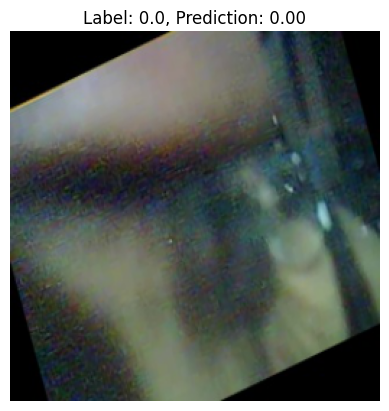

In [36]:
# Show a random image from the test set
# show the predicted value and the actual value
# use matplotlib to show the image

import matplotlib.pyplot as plt
import random
import numpy as np


def show_image(image, label, prediction):
    image = image.permute(1, 2, 0).cpu().numpy()  # Change the order of dimensions
    image = np.clip(image, 0, 1)  # Ensure values are between 0 and 1
    plt.imshow(image)
    plt.title(f"Label: {label}, Prediction: {prediction:.2f}")
    plt.axis("off")
    plt.show()


# Show a random image from the test set
random_index = random.randint(0, len(test_dataset) - 1)
image, label = test_dataset[random_index]
image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
with torch.no_grad():
    prediction = model(image).item()  # Get the prediction
show_image(image.squeeze(), label.item(), prediction)


In [6]:
torch.save(model.state_dict(), "eye_openness_model.pth")
print("Model saved as eye_openness_model.pth")

Model saved as eye_openness_model.pth


In [ ]:
# take some 10 random images from the test set and save them
# with the predicted value and the actual value

import matplotlib.pyplot as plt
import random
import numpy as np


def save_image(image, label, prediction, index):
    image = image.permute(1, 2, 0).cpu().numpy()  # Change the order of dimensions
    image = np.clip(image, 0, 1)  # Ensure values are between 0 and 1
    plt.imshow(image)
    plt.title(f"Label: {label:.2f}, Prediction: {prediction:.2f}")
    plt.axis("off")
    plt.savefig(f"o
    plt.close()


# Create a directory to save the images
output_dir = "output_images"
os.makedirs(output_dir, exist_ok=True)

# Save 10 random images from the test set
for i in range(10):
    random_index = random.randint(0, len(test_dataset) - 1)
    image, label = test_dataset[random_index]
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
    with torch.no_grad():
        prediction = model(image).item()  # Get the prediction
    save_image(image.squeeze(), label.item(), prediction, i)
    print(f"Saved image_{i}.png with Label: {label:.2f}, Prediction: {prediction:.2f}")


Saved image_0.png with Label: 0.50, Prediction: 0.39
Saved image_1.png with Label: 0.75, Prediction: 0.76
Saved image_2.png with Label: 1.00, Prediction: 1.04
Saved image_3.png with Label: 0.75, Prediction: 0.70
Saved image_4.png with Label: 0.75, Prediction: 0.62
Saved image_5.png with Label: 1.00, Prediction: 0.75
Saved image_6.png with Label: 0.25, Prediction: 0.26
Saved image_7.png with Label: 0.50, Prediction: 0.53
Saved image_8.png with Label: 0.00, Prediction: 0.23
Saved image_9.png with Label: 0.75, Prediction: 0.82


In [ ]:
# 